In [58]:
# Initialize
import susan
import glob
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter,binary_dilation,binary_erosion,median_filter
from skimage.measure import block_reduce #scikit-image module
from skimage.morphology import skeletonize_3d

import csv
import os

In [13]:
# %% Create Tomostxt for SUSAN to find your data.
N = 11 # Number of tilt series
K = 35 # Max number of tilts per series. Here I used 3° tilt increments => ~35 tilts/TS. For 2° tilt increment it's rather around 53. 

tomos = susan.data.Tomograms(n_tomo=N,n_proj=K) # Initialize Tomo Class
apix  = 3.033 # Pixel size
tilting_step=3 # Tilt increment
tsiz  = np.array((4096,4096,1200)) # Tomo size. Caution: make sure this corresponds to the tomo thickness used for particle picking......................
tomolist=(1,2,3,4,5,6,7,9,10,11,12) # Caution: harcoded naming convention: 3-digit names for your tomograms. No pre/suffix, just the number. If you merge datasets, you can increment the first digit for next datasets to make tomonames unique (001 becomes 101 for instance).
binningList=(1,2,4,8,16)


##Some hardcoded names and values in the paragraph below ; pay attention#############################################
for b in binningList:  # for each binning step
    for i in range(N): # for each tomo
        base = '/home/gemin/dR-S/DATA/%03d' % (tomolist[i])
        tomos.tomo_id[i] = tomolist[i]
        tomos.set_stack  (i,base+'.bin%i.atALI.mrc' % (b))
        tomos.set_angles (i,base+'.bin%i.atALI.tlt' % (b))
        tomos.set_defocus(i,base+'.defocus') # z# z# tlt tlt dfU(nm) dfV(nm) dfAzimuth    in tuto file.
                # actually, if 1st line ends in 3 (=version 3) => next lines: dummy dummy dummy dummy dfU(nm) dfV(nm) dfAzimuth
        tomos.pix_size[i]  = apix*b
        tomos.tomo_size[i] = np.uint32(np.ceil(tsiz/b))
        # Read the angles
        tilt_angles = tomos.proj_eZYZ[:,:,1] # get the Y component of the euler angles.
        # Set the Exposure filtering / Dose weighting
        weight_per_tilt = 4
        tomos.def_ExFl = weight_per_tilt * np.round( np.abs(tilt_angles)/tilting_step )
        # Set the maximum resolution per projection. 
        tomos.def_mres = 20*(tilt_angles/60)**2
    tomos.save('tomos_b%i.tomostxt' % (b))

# Show values for Qcheck.
tomos_B1 = susan.read('tomos_b1.tomostxt')
tomo_ix = 0
print('Angle   Dose Wgt   Max. Res.')
for i in range(tomos.num_proj[tomo_ix]):
    print('%5.1f:   %5.1f       %5.2f'%(tilt_angles[tomo_ix,i],
                                        tomos_B1.def_ExFl[tomo_ix,i],
                                        tomos_B1.def_mres[tomo_ix,i]))
# A way to check if TS has correct handedness is to compare the #Thon rings @ tomos.eZYZ and -tomos.eZYZ (should have less.)

Angle   Dose Wgt   Max. Res.
-43.0:    56.0       10.27
-40.0:    52.0        8.88
-37.0:    48.0        7.60
-34.0:    44.0        6.42
-31.0:    40.0        5.34
-28.0:    36.0        4.35
-25.0:    32.0        3.47
-22.0:    28.0        2.69
-19.0:    24.0        2.00
-16.0:    20.0        1.42
-13.0:    16.0        0.94
-10.0:    12.0        0.56
 -7.0:     8.0        0.27
 -4.0:     4.0        0.09
 -1.0:     0.0        0.01
  2.0:     4.0        0.02
  5.0:     8.0        0.14
  8.0:    12.0        0.35
 11.0:    16.0        0.67
 14.0:    20.0        1.09
 17.0:    24.0        1.60
 20.0:    28.0        2.22
 23.0:    32.0        2.94
 26.0:    36.0        3.75
 29.0:    40.0        4.67
 32.0:    44.0        5.69
 35.0:    48.0        6.80
 38.0:    52.0        8.02
 41.0:    56.0        9.33
 44.0:    60.0       10.75
 47.0:    64.0       12.27
 50.0:    68.0       13.88
 53.0:    72.0       15.60


In [15]:
# Particle picking == grab dark clusters. A simplified version @github/ImageAnalysis/BlobPicking.py

QchkFlag=1 # Kwaliti czech

root='/home/gemin/dR-S/DATA/'
tomoPath=''
outPath='blobPicks/'
chkPath='tmp/'

tomolist={1,2,3,4,5,6,7,9,10,11,12}   # not parentheses this time {:
b=8 # binning used for picking
tomos = susan.read('tomos_b%i.tomostxt'%b) # load data
tomoDim=(512,512,150) # Declare tomo size. Make sure it fits with tomos.tomo_size[i] in the .tomostxt files.

trimVal=30  # XY border trim, in binned pixels        
ZtrimVal=25 # idem for Z

ProxClnFlag=1 # Remove 3D-clustered particles (picking being done in 2D here, that's useful.)
proxThr = 7 # ProxiThreshold in binned px  (5 was too small to do anything)      HARDCODED

# Parameters to tweak to limit false posi/negatives
S = 1  # Shrink factor < picking worked for me at ~30Å/px
g1 = 2 # cutoff 1
g2 = 7 # cutoff 2
thr= -0.44 # Skeletonizing threshold

##########################################################

tid_list=tomolist
#tid_list = {9}    # to exclude sub-par TSs remove them from tid_list

Xmin=trimVal ; Xmax=tomoDim[0]-trimVal
Ymin=trimVal ; Ymax=tomoDim[1]-trimVal
Zmin=ZtrimVal ; Zmax=tomoDim[2]-ZtrimVal

pts = np.zeros((0,3),np.float32) # Coordinates 
tid = np.zeros((0,1),np.uint32)  # tomoID list
ccc = np.zeros((0,1),np.float32) # cross-corr ?

for i in tid_list:
        tomoName = root+tomoPath+'%03i.bin%i.at.mrc'%(i,b)
        v,p = susan.io.mrc.read(tomoName) # v,p = volume (b8.rec),_unusedVar_
        v   = (v-v.mean())/v.std() # normalize
        v   = gaussian_filter(v,g1) # blur                HARDCODED
        v   = v - gaussian_filter(v,g2) # bandpass        HARDCODED
        vv  = block_reduce(v,(S,S,S),np.min) # skimage.measure.block_reduce by S=6 ?? Shrink ?       
        vvg = skeletonize_3d((vv<thr))       #HARDCODED
        tmp = np.argwhere(vvg>0) # get coordinates of all ones. tmp.shape = (N,3)
        print( 'Tomo %2d: %6d'%(i,tmp.shape[0])) #chk
        pts = np.vstack((pts,tmp)) # list pts as x,y,z coordinates << increasing in size at each iteration
        tid = np.vstack((tid,i*np.ones((tmp.shape[0],1)))) # fill tid($i) with a list of $i, the size of tmp
        ccv = gaussian_filter(np.float32(vvg),1) # blur skeleton
        ccp = ccv[tmp[:,0],tmp[:,1],tmp[:,2]] # grey score
        ccc = np.vstack((ccc,ccp[:,np.newaxis])) # formatted
        if QchkFlag==1:
            susan.io.mrc.write(np.float32(v),root+tomoPath+chkPath+'%03i-1-v_g%i-g%i.rec'%(i,g1,g2))         
            susan.io.mrc.write(np.float32(vv),root+tomoPath+chkPath+'%03i-2-vv_blkRed%i.rec'%(i,S))
            susan.io.mrc.write(np.float32(vvg),root+tomoPath+chkPath+'%03i-3-vvg_skel3D%i.rec'%(i,thr))
            susan.io.mrc.write(np.float32(ccv),root+tomoPath+chkPath+'%03i-4-ccv_skel3D-blur1.rec'%i)

pts = S*pts + S/2 # Un-shrink coordinates
ix  = (pts[:,0]>Zmin) & (pts[:,1]>Ymin) & (pts[:,2]>Xmin) & (pts[:,0]<Zmax) & (pts[:,1]<Ymax) & (pts[:,2]<Xmax) # Trim tomo borders (XZ swapped for some reason)
pts = pts[ix>0] ; tid = tid[ix>0] ; ccc = ccc[ix>0] 
print(pts.shape) #chk
pos = np.vstack( (pts[:,2],pts[:,1],pts[:,0]) ).transpose()
p = susan.data.Particles.import_data(tomograms=tomos,tomos_id=tid.flatten(),position=pos)
p.ali_cc[0,:] = ccc.flatten()
p.save(root+outPath+'g%i-%i-S%ithr%ionB%i_picking-noProxiCln.ptclsraw'%(g1,g2,S,thr,b))

if ProxClnFlag==1:
    p = susan.data.Particles.Geom.discard_closer(p,b*proxThr,verbose=True)
    p.save(root+outPath+'g%i-%i-S%ithr%ionB%i_picking-ProxiCln%i.ptclsraw'%(g1,g2,S,thr,b,proxThr))
    #modName='posCln%i'%(proxThr)
    
print('Done!')

Tomo  1:  11617
Tomo  2:   9039
Tomo  3:  11709
Tomo  4:  15355
Tomo  5:  10617
Tomo  6:  10730
Tomo  7:  18882
Tomo  9:  13447
Tomo 10:  10732
Tomo 11:  10045
Tomo 12:   6850
(73238, 3)
73238 particles in 11 tomograms. Processing:
	Tomogram index   0: from    6030 to    2282 particles.
	Tomogram index   1: from    4819 to    1760 particles.
	Tomogram index   2: from    7617 to    2822 particles.
	Tomogram index   3: from   10229 to    3855 particles.
	Tomogram index   4: from    5617 to    2039 particles.
	Tomogram index   5: from    6581 to    2529 particles.
	Tomogram index   6: from   12592 to    4660 particles.
	Tomogram index   7: from    6199 to    2342 particles.
	Tomogram index   8: from    6429 to    2441 particles.
	Tomogram index   9: from    5020 to    1905 particles.
	Tomogram index  10: from    2105 to     861 particles.
Remaining particles: 27496
Done!


In [17]:
# Save .mod files to check picking

modSphSize = 8 # 5 for dD

for i in tid_list:
    modname='tomo%i_cln7'%i
    p1=p[p.tomo_id==i] #get particles with tomoID == i
    pos = p1.export_positions(tomos)
    np.savetxt(root+tomoPath+modname+'.txt',pos)
    print('checkable in IMOD after : point2model -in '+modname+'.txt -ou '+modname+'.mod -sc -sp %i'%modSphSize)

checkable in IMOD after : point2model -in tomo1_cln7.txt -ou tomo1_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo2_cln7.txt -ou tomo2_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo3_cln7.txt -ou tomo3_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo4_cln7.txt -ou tomo4_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo5_cln7.txt -ou tomo5_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo6_cln7.txt -ou tomo6_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo7_cln7.txt -ou tomo7_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo9_cln7.txt -ou tomo9_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo10_cln7.txt -ou tomo10_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo11_cln7.txt -ou tomo11_cln7.mod -sc -sp 8
checkable in IMOD after : point2model -in tomo12_cln7.txt -ou tomo12_cln7.mod -sc -sp 8


In [ ]:
# Clean list in IMOD 
# Edit>Object>Type: open ; Special>DrawingTools>[7]Eraser ; Save model as $mod-manuCLN.mod
# Keep an eye on V: 3d view for visu feedback

# Convert "motl" back mod>csv>ptclsraw ; see mod2csv.cmd (shrinks spaces, removes initial space).
# for i in `cat no0tomo.list` ; do model2point tomo${i}_cln7-manuCLN.mod tomo${i}_cln7-manuCLN.csv ; SDG "  " " " tomo${i}_cln7-manuCLN.csv ; SDG "  " " " tomo${i}_cln7-manuCLN.csv ; SDG "  " " " tomo${i}_cln7-manuCLN.csv ; SDG "  " " " tomo${i}_cln7-manuCLN.csv ; SDG "^ " "" tomo${i}_cln7-manuCLN.csv ; done

In [18]:
# -manuCLN.mod 2 .ptclsraw

root='/home/gemin/dR-S/DATA/'
inPath=''
path=root+inPath
outPath=''
O='allt_blobPickCln7+manuCLN.ptclsraw'

tomos = susan.read('tomos_b8.tomostxt')
#inputPtcls='blobPickCln7+manuAdditions018.ptclsraw'
tid=np.array([])
pos=[]
for i in [1,2,3,4,5,6,7,9,10,11,12]:
    with open(path+'tomo%i_cln7-manuCLN.csv'%i, newline='') as csvfile:
        datareader = csv.reader(csvfile, delimiter=' ', quotechar='|')
        for row in datareader:
            data=list(map(float,row))
            data=list(map(round,data))
            data=list(map(int,data))
            pos.append(data)
#     print(len(pos))
    tid=list(tid)+list(i*np.ones((len(pos)-len(tid),1))) #   !&%@*$#Q)
    print(len(tid))
pos=np.array(pos)
print(pos[0])
# ccc=np.ones((len(pos)))
print(pos.shape)
tid=np.array(tid)
print(tid.shape)
tid=tid.flatten()
print(tid.shape)

p_out = susan.data.Particles.import_data(tomograms=tomos,tomos_id=tid,position=pos)
# p_out.ali_cc = ccc
# p_out.save(root+outPath+'t9t18_blobPickCln7+manuCLN.ptclsraw')
p_out.save(root+outPath+O)

1400
2656
3582
4605
5403
6415
7213
7638
8281
9059
9593
[222 122  32]
(9593, 3)
(9593, 1)
(9593,)


In [19]:
#Seed particles with random angles + set halfsets_by_Y() to 1
I='DATA/allt_blobPickCln7+manuCLN.ptclsraw'
O='allt_blobPickCln7+manuCLN-rndAng.ptclsraw'
p=susan.data.Particles(I)
p.halfsets_by_Y()

print(p.ali_eu.shape)
angleNum=p.ali_eu.shape[0]*p.ali_eu.shape[1]*p.ali_eu.shape[2]
a=np.array([np.random.uniform(-3.14,+3.14) for _ in range(angleNum)])
print(a.shape)
a=a.reshape(p.ali_eu.shape)
print(a.shape)

p.ali_eu=a
p.save(O)

(1, 9593, 3)
(28779,)
(1, 9593, 3)


    Volume reconstruction. Box size: 24
    - [ allt_blobPickCln7+manuCLN-rndAng.ptclsraw | tomos_b8.tomostxt ] -> [ Prefix: prj_000 ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 11.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 9593 Particles (1 classes) in 11 tomograms with max 35 projections.
    Filling fourier space: 100.00%                                  
        Reconstructing prj_000_class001.mrc ...  Done.


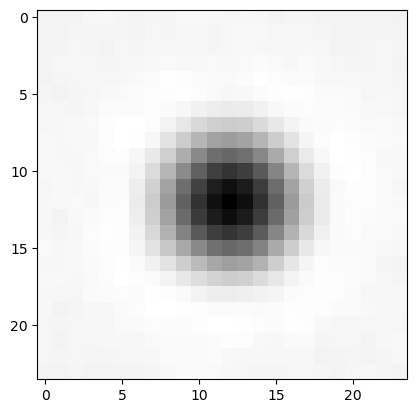

In [20]:
# %% Check an average ___before moving on to CTF "refinement" = estimation using SUSAN vs ctffind___
avgr = susan.modules.Averager() ; avgr.list_gpus_ids  = [0,1] ; avgr.ctf_correction = 'wiener' ; avgr.rec_halfsets   = False
prj='prj_000'
ptcls='allt_blobPickCln7+manuCLN-rndAng.ptclsraw'
box=24
avgr.reconstruct(prj,'tomos_b8.tomostxt',ptcls,box) # (outputName,tomos,ptcls,box_size)
# Initial reconstruction
v,_ = susan.io.mrc.read(prj+'_class001.mrc')
plt.imshow(v[box//2],'gray')

In [22]:
# Update ctf info ?

# First trim list so it doesn't take forever.
ptcls='allt_blobPickCln7+manuCLN-rndAng' #blobPickCln7+manuAdditions018-rndAng' #.ptclsraw
o='DATA/'+ptcls+'-SPARSE4ctfEstimation.ptclsraw'
# Discard closer
p0 = susan.read(ptcls+'.ptclsraw')
p1 = susan.data.Particles.Geom.discard_closer(p0,2*190,verbose=True)
p1.save(o)
print(o)

9593 particles in 11 tomograms. Processing:
	Tomogram index   0: from    1400 to     570 particles.
	Tomogram index   1: from    1256 to     509 particles.
	Tomogram index   2: from     926 to     363 particles.
	Tomogram index   3: from    1023 to     288 particles.
	Tomogram index   4: from     798 to     346 particles.
	Tomogram index   5: from    1012 to     438 particles.
	Tomogram index   6: from     798 to     357 particles.
	Tomogram index   7: from     425 to     228 particles.
	Tomogram index   8: from     643 to     301 particles.
	Tomogram index   9: from     778 to     358 particles.
	Tomogram index  10: from     534 to     291 particles.
Remaining particles: 4049
DATA/allt_blobPickCln7+manuCLN-rndAng-ctf.ptclsraw


In [23]:
# %% Per particle ctf estimation
ptcls=o #

ctf = susan.modules.CtfEstimator()
ctf.list_gpus_ids = [0,1] # must be defined.
ctf.binning = 0
ctf.verbose = 2 # Create a 1D fitting graph. (2:2D image)
ctf.defocus_angstroms.min_val = 20000
ctf.defocus_angstroms.max_val = 70000
ctf.resolution_angs.min_val = 30
ctf.resolution_angs.max_val = 8
ctf.estimate('ctf_est','tomos_b1.tomostxt',ptcls,512)

#Run on cluster using   sbatch -p gpu-el8 -N 1 --gres=gpu:8 --mem-per-gpu 24G -C gpu=3090 --cpus-per-gpu 8 ./B_ctf.sh
# => outputs ctf_est/TOMO0xx/...
#ctf_average.mrc      ctf_fitting_result.mrc  ctf_normalized_raw.mrc  ctf_ps_lin_raw.mrc
#ctf_average_raw.mrc  ctf_linearized.mrc      ctf_ps_lin_avg.mrc      defocus.txt
#ctf_fit              ctf_normalized.mrc      ctf_ps_lin.mrc


	Ctf Estimation:
		Particles file: DATA/allt_blobPickCln7+manuCLN-rndAng-ctf.ptclsraw.
		Tomograms file: tomos_b1.tomostxt.
		Output folder: ctf_est.
		Patch size: 512x512, no binning.
		Using 2 GPUs (GPU ids: 0,1), and 2 threads.
		Resolution range: 30.0 - 8.0 Å.
		Defocus range: 20000.00 - 70000.00 Å.
		Tilt search range: 3000.0 Å.
		Defocus refinement range: 2000.00 Å.
		Defocus refinement step: 100.00 Å.
      - Tomo   1 [  570 particles]: 100.00%. Initial tomogram Defocus:  33373.0 Å
        Normalizing [  570 particles]: 100.00%.
        Avg defocus: U=  33653Å, V=  32963Å, angle=    1º.
      - Tomo   2 [  509 particles]: 100.00%. Initial tomogram Defocus:  38993.8 Å
        Normalizing [  509 particles]: 100.00%.
        Avg defocus: U=  39187Å, V=  38362Å, angle=    3º.
      - Tomo   3 [  363 particles]: 100.00%. Initial tomogram Defocus:  44352.6 Å
        Normalizing [  363 particles]: 100.00%.
        Avg defocus: U=  44392Å, V=  44080Å, angle=    5º.
      - Tomo   4 [  2

Checking Thon rings for tomo 001
Central tilt
Extreme tilt
Checking Thon rings for tomo 012
Central tilt
Extreme tilt


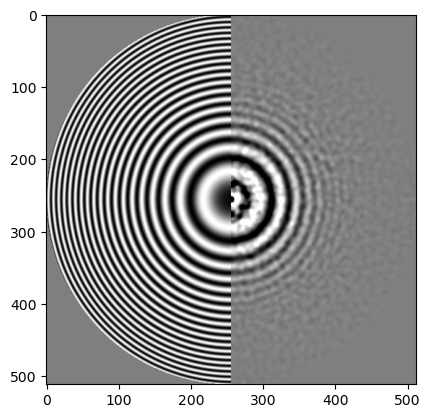

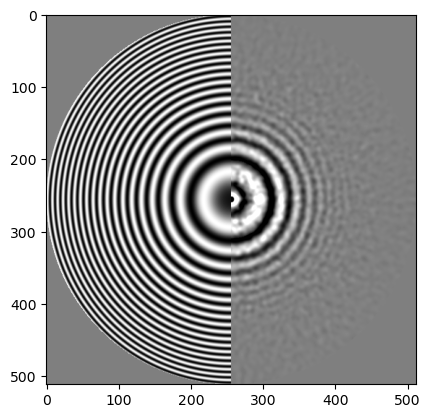

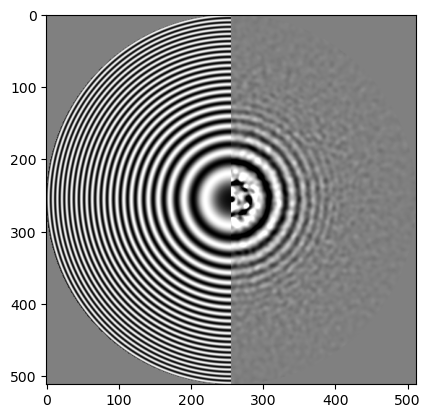

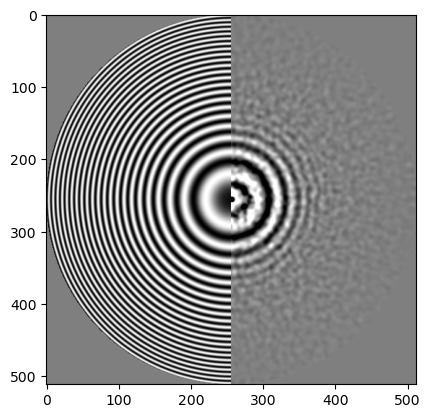

In [24]:
for i in ('001','012'):
    print('Checking Thon rings for tomo '+i)
    stk = susan.read('ctf_est/Tomo'+i+'/ctf_fitting_result.mrc')
    plt.figure()
    print('Central tilt')
    plt.imshow(stk[25],'gray')
    plt.figure()
    print('Extreme tilt')
    plt.imshow(stk[0],'gray')

In [25]:
# %% Update Tomostxt defocus values:
# Before that, $ for i in 1 2 4 8 16 ; do SDG 'S\/DATA' 's\/DATA' tomos_b${i}-SCRATCH.tomostxt; done
tomolist=(1,2,3,4,5,6,7,9,10,11,12)
for b in {1,2,4,8,16}:
    for suffix in {'','-SCRATCH'}:
        tName='tomos_b%i'%(b)+suffix+'.tomostxt'
        tomos=susan.read(tName)
        for i in range(len(tomolist)):
            tomos.set_defocus(i,'ctf_est/Tomo%03d/defocus.txt'%tomolist[i])
        tomos.save(tName)

In [26]:
# %% Update Ptclsraw defocus values:
# p_in='blobPickCln7+manuAdditions018-rndAng.ptclsraw'
# p_out='blobPickCln7+manuAdditions018-rndAng-UpdatedppCtf.ptclsraw'
path=''
base=path+'allt_blobPickCln7+manuCLN-rndAng'
p_in=base+'.ptclsraw'
p_out=base+'-SusanCtf.ptclsraw'

tomoB1 = susan.read('tomos_b1.tomostxt')
ptcls  = susan.read(p_in)
ptcls.update_defocus(tomoB1) #per particle ! (;
ptcls.save(p_out)

    Volume reconstruction. Box size: 64
    - [ allt_blobPickCln7+manuCLN-rndAng-SusanCtf.ptclsraw | tomos_b4.tomostxt ] -> [ Prefix: prj_0 ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 31.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 9593 Particles (1 classes) in 11 tomograms with max 35 projections.
    Filling fourier space: 100.00%                                  
        Reconstructing prj_0_class001.mrc ...  Done.


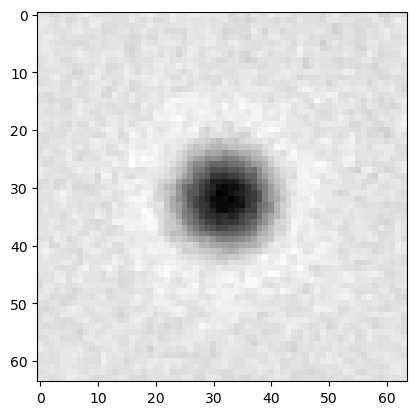

In [27]:
# %% Check an average ___before moving on to STA___
avgr = susan.modules.Averager() ; avgr.list_gpus_ids  = [0,1] ; avgr.ctf_correction = 'wiener' ; avgr.rec_halfsets   = False
prj='prj_0'
ptcls='allt_blobPickCln7+manuCLN-rndAng-SusanCtf.ptclsraw'
box=64
avgr.reconstruct(prj,'tomos_b4.tomostxt',ptcls,box) # (outputName,tomos,ptcls,box_size)
# Initial reconstruction
v,_ = susan.io.mrc.read(prj+'_class001.mrc')
plt.imshow(v[box//2],'gray')

    Volume reconstruction. Box size: 32
    - [ iniTomoTestRec/1.ptclsraw | tomos_b8.tomostxt ] -> [ Prefix: iniTomoTestRec/1 ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 15.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 1400 Particles (1 classes) in 11 tomograms with max 35 projections.
    Filling fourier space: 100.00%                                  
        Reconstructing iniTomoTestRec/1_class001.mrc ...  Done.
    Volume reconstruction. Box size: 32
    - [ iniTomoTestRec/2.ptclsraw | tomos_b8.tomostxt ] -> [ Prefix: iniTomoTestRec/2 ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 15.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 1256 Particles (1 classes) in 11 tomograms with max 35 projections.
    Filling fourier space: 100.00%                                  
        Reconstruc

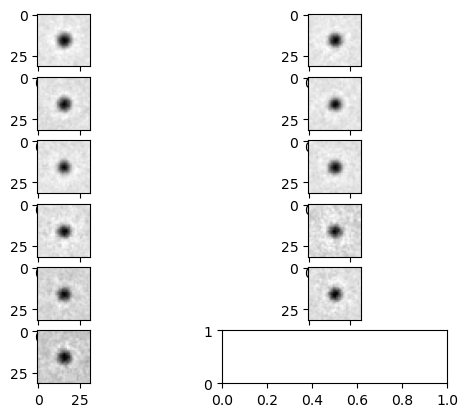

In [56]:
# Test to check that all TSs behave :
p=susan.data.Particles('allt_blobPickCln7+manuCLN-rndAng-SusanCtf.ptclsraw')
tomolist=(1,2,3,4,5,6,7,9,10,11,12)
b=8 # binning
box=32
Ofldr='iniTomoTestRec/'


#############################################
_=os.system('mkdir '+Ofldr)

avgr = susan.modules.Averager() ; avgr.list_gpus_ids  = [0,1] ; avgr.ctf_correction = 'wiener' ; avgr.rec_halfsets   = False
txt='tomos_b%i.tomostxt'%b

for i in tomolist:
    pi=p.select(p.tomo_id==i)
    prj=Ofldr+'%i'%i
    pi.save(prj+'.ptclsraw')    
    avgr.reconstruct(prj,txt,prj+'.ptclsraw',box) # (outputName,tomos,ptcls,box_size)
    
fig,axs=plt.subplots(6,2)
print(np.reshape(list(tomolist)+[0],(6,2)))
c=0
for i in tomolist:
    prj=Ofldr+'%i'%i
    v,_ = susan.io.mrc.read(prj+'_class001.mrc')
    axs[c//2,c%2].imshow(v[box//2],'gray')
    c+=1

In [ ]:
# STA on the cluster using template python scripts ! (:

mkdir: cannot create directory ‘ccTests/’: File exists


(9121,)
(8296,)
prj_01-i16-dstCLN15b4-ccCLN0.020IN.ptclsraw prj_01-i16-dstCLN15b4-ccCLN0.020OUT.ptclsraw


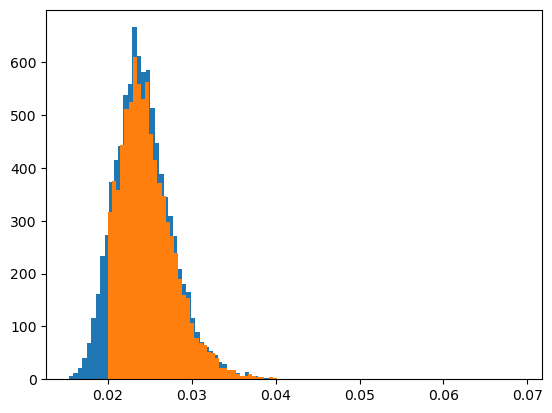

In [82]:
#ccCLN: check the distribution of cross-correlation scores between particles and the reference. If bimodal, you might want to filter out the lower mode.
prj='prj_01'
ite=15
ccTh=0.02
Ofldr='ccTests/'
_=os.system('mkdir '+Ofldr)
    
saveFlag=1

#From prj/
I=prj+'/ite_%04i/particles.ptclsraw'%ite
Oin= Ofldr+prj+'-i%i-ccCLN%.3fIN.ptclsraw'%(ite,ccTh)
Oout=Ofldr+prj+'-i%i-ccCLN%.3fOUT.ptclsraw'%(ite,ccTh)

#From elsewhere
I='prj_01-i16-dstCLN15b4.ptclsraw'
Oin= I[:-9]+'-ccCLN%.3fIN.ptclsraw'%(ccTh)
Oout=I[:-9]+'-ccCLN%.3fOUT.ptclsraw'%(ccTh)

p0 = susan.data.Particles(I) # Input argument : iteration number
print (p0.ali_cc[0].shape)
_ = plt.hist(p0.ali_cc[0],100)

p1=p0.select( (p0.ali_cc[0]>ccTh))
_ = plt.hist(p1.ali_cc[0],100)
print (p1.ali_cc[0].shape)

print(Oin)
print(Oout)
if saveFlag==1:
    p1.save(Oin)
    if ccTh>np.min(p0.ali_cc[0]):
        p2=p0.select((p0.ali_cc[0]<ccTh))
        p2.save(Oout)


    Volume reconstruction. Box size: 64
    - [ ccTests/prj_01-i15-ccCLN0.015IN.ptclsraw | tomos_b4.tomostxt ] -> [ Prefix: ccTests/prj_01-i15-ccCLN0.015IN ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 31.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 8549 Particles (1 classes) in 11 tomograms with max 35 projections.
    Filling fourier space: 100.00%                                  
        Reconstructing ccTests/prj_01-i15-ccCLN0.015IN_class001.mrc ...  Done.
    Volume reconstruction. Box size: 64
    - [ ccTests/prj_01-i15-ccCLN0.015OUT.ptclsraw | tomos_b4.tomostxt ] -> [ Prefix: ccTests/prj_01-i15-ccCLN0.015OUT ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 31.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 1044 Particles (1 classes) in 11 tomograms with max 35 projections.
    Fillin

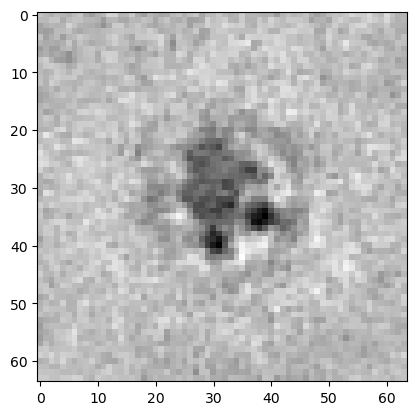

In [72]:
# %% Check an average
avgr = susan.modules.Averager() ; avgr.list_gpus_ids  = [0,1] ; avgr.ctf_correction = 'wiener' ; avgr.rec_halfsets   = False
Ifldr='ccTests/'
#I=Ifldr+'prj_2-i8-ccCLN0.017.ptclsraw'
for I in (Oin,Oout):
    O=I[:-9]
    box=64
    avgr.reconstruct(O,'tomos_b4.tomostxt',I,box) # (outputName,tomos,ptcls,box_size)
    # Initial reconstruction
    v,_ = susan.io.mrc.read(O+'_class001.mrc')
    plt.imshow(v[box//2],'gray')

In [101]:
# Clean by distance
prj='prj_01'
ite=16
I=prj+'/ite_%04i/particles.ptclsraw'%ite

b=4 #binning 
dstTh=36  # in binned pixels  ; @bin4, ribo diameter ~20px
DT=b*dstTh # in unbinned pixels

Ofldr=''
O=Ofldr+prj+'-i%i-dstCLN%ib%i.ptclsraw'%(ite,dstTh,b)

p = susan.data.Particles(I)
p = susan.data.Particles.Geom.discard_closer(p,DT,verbose=True)
p.save(O)
print(O)

9593 particles in 11 tomograms. Processing:
	Tomogram index   0: from    1400 to    1087 particles.
	Tomogram index   1: from    1256 to     994 particles.
	Tomogram index   2: from     926 to     757 particles.
	Tomogram index   3: from    1023 to     752 particles.
	Tomogram index   4: from     798 to     647 particles.
	Tomogram index   5: from    1012 to     818 particles.
	Tomogram index   6: from     798 to     656 particles.
	Tomogram index   7: from     425 to     375 particles.
	Tomogram index   8: from     643 to     553 particles.
	Tomogram index   9: from     778 to     645 particles.
	Tomogram index  10: from     534 to     479 particles.
Remaining particles: 7763
prj_01-i16-dstCLN36b4.ptclsraw


In [102]:
#ptclsraw2star4bd

# First edit blenderStarHeader to fit your needs !   

# Format data as "proto-star" : dummyName(=0) x y z r t p opticsGrp(=1)
# r t p in degrees and ZYZ convention

#I='prj_b61/ite_0035/particles.ptclsraw'
#O='prj_b61-i1.bd.star'
Ilist=('prj_01-i16-dstCLN15b4.ptclsraw','prj_01-i16-dstCLN15b4-ccCLN0.020IN.ptclsraw')
Ilist=(['prj_01-i16-dstCLN36b4.ptclsraw'])
for I in Ilist:
    print(I)
    O=I[:-8]+'bd.star'
    starHdr='blenderStarHeader.star'
    binning=4
    ttxt='tomos_b%i.tomostxt'%binning
    tomos = susan.read(ttxt)

    ptot=susan.data.Particles(I)
    p=ptot.select(ptot.tomo_id==12)
    #p=ptot
    pos=p.export_positions(tomos)
    ang=p.ali_eu[0]*180/np.pi
    dmy0=np.zeros((1,ang.shape[0]))
    dmy1=np.ones((1,ang.shape[0]))
    data=np.concatenate((dmy0,pos.T,ang.T,dmy1)).T

    # Seed output.star with a header
    _=os.system('rsync -avz '+starHdr+' '+O)

    with open(O, 'a') as file:
            for row in data:
                file.write(' '.join([str(a) for a in row]) + '\n')

prj_01-i16-dstCLN36b4.ptclsraw
sending incremental file list
starHeader.star

sent 359 bytes  received 35 bytes  788.00 bytes/sec
total size is 526  speedup is 1.34


    Volume reconstruction. Box size: 64
    - [ prj_01-i15-dstCLN19b4.ptclsraw | tomos_b4.tomostxt ] -> [ Prefix: prj_01-i15-dstCLN19b4 ]
    - 2 GPUs (GPU ids: 0,1),  2 threads.
    - Bandpass: [0.0 - 31.0] (Smooth decay: 2.00). c1 Symmetry.
    - Wiener Inversion. Normalization (Mean=0, Std=1).
	Loading data files... Done
    - 8915 Particles (1 classes) in 11 tomograms with max 35 projections.
    Filling fourier space: 100.00%                                  
        Reconstructing prj_01-i15-dstCLN19b4_class001.mrc ...  Done.


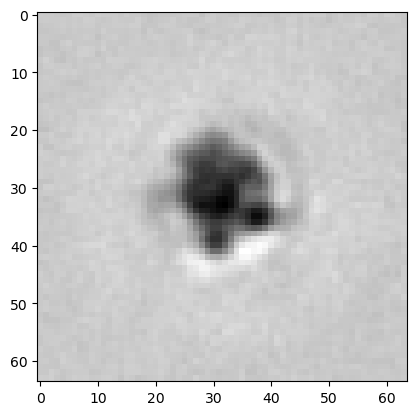

In [66]:
# %% Check an average
avgr = susan.modules.Averager() ; avgr.list_gpus_ids  = [0,1] ; avgr.ctf_correction = 'wiener' ; avgr.rec_halfsets   = False
Ifldr='./'
#I=Ifldr+'prj_2-i8-ccCLN0.017.ptclsraw'
I=O # from last box.
O=I[:-9]
box=64
b=4
avgr.reconstruct(O,'tomos_b%i.tomostxt'%b,I,box) # (outputName,tomos,ptcls,box_size)
# Initial reconstruction
v,_ = susan.io.mrc.read(O+'_class001.mrc')
plt.imshow(v[box//2],'gray')

In [ ]:
# Good luck ! (:
# O.